<a href="https://colab.research.google.com/github/MaiLiinhHooang/GitWorkFlow/blob/main/NEMO_2_sub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%R
install.packages("tidyr", quietly = TRUE)
install.packages("tidyverse", quietly = TRUE)
install.packages ("dplyr", quietly = TRUE)
install.packages("SNFtool")
install.packages("survival")
devtools::install_github('Shamir-Lab/NEMO/NEMO')

(as ‘lib’ is unspecified)







	‘/tmp/RtmptqTNwl/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmptqTNwl/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmptqTNwl/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmptqTNwl/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmptqTNwl/downloaded_packages’

  Use `force = TRUE` to force installation



In [ ]:
%%R
library(tidyr)
library(tidyverse)
library(dplyr)
library(SNFtool)
library(survival)
library(NEMO)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ purrr     1.0.2
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.1     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [ ]:
%%R
meth <- read.table("/content/drive/MyDrive/Data/data_methylation_hm27_hm450_merged.txt", sep='\t', row.names = NULL, check.names = FALSE, header = TRUE)
mirna <- read.table("/content/drive/MyDrive/Data/data_mrna_seq_v2_rsem_zscores_ref_diploid_samples.txt", sep='\t', row.names = NULL, check.names = FALSE, header = TRUE)
rna <- read.table("/content/drive/MyDrive/Data/data_cna.txt", sep='\t', row.names = NULL, check.names = FALSE, header = TRUE)

In [ ]:
%%R
#Data Pre-processing
##RNA0
rna = rna[,-2]
rna$Hugo_Symbol <- make.unique(as.character(rna$Hugo_Symbol))
rownames(rna) <- rna$Hugo_Symbol
rna = rna[,-1]
dim(rna)

##MET(!!!)
meth = meth[,-1]
meth = meth[,-2]
meth = meth[,-2]
meth <- meth[!is.na(meth$NAME), ]
meth$NAME <- make.unique(as.character(meth$NAME))
rownames(meth) <- meth$NAME
meth = meth[,-1]
dim(meth)

##exp
mirna = mirna[,-2]
mirna$Hugo_Symbol <- make.unique(as.character(mirna$Hugo_Symbol))
rownames(mirna) <- mirna$Hugo_Symbol
mirna = mirna[,-1]
dim(mirna)

[1] 20471   366


In [ ]:
%%R
### Pre-process Clinical data
cli = read.table('/content/drive/MyDrive/Data/data_clinical_patient.txt', sep='\t', row.names = 1,  check.names = FALSE, header = TRUE, fill=TRUE)
rownames(cli) = paste(rownames(cli), "", sep = "-01") #rename rows
#cli_patient_lihc = na_if(cli, "[Not Available]") #transform [Not Available] into NA value
cli_patient_lihc <- cli %>% mutate(across(everything(), ~na_if(as.character(.), "[Not Available]")))
cli_patient_lihc$status = ifelse(cli_patient_lihc$`OS_STATUS` == '1:DECEASED',1,0) #create binary statuss
cli_patient_lihc$time = cli_patient_lihc$`DAYS_LAST_FOLLOWUP`
cli_patient_lihc$AGE <- as.numeric(cli_patient_lihc$AGE)
cli_patient_lihc <- cli_patient_lihc[!is.na(cli_patient_lihc$AGE), ]
cli_patient_lihc$time <- as.numeric(cli_patient_lihc$time)
cli_patient_lihc <- cli_patient_lihc[!is.na(cli_patient_lihc$time), ]
dim(cli_patient_lihc)

[1] 280  39


In [ ]:
%%R
#Retain patients sharing among three datasets
srna_lihc<-colnames(rna)
smirna_lihc<-colnames(mirna)
smet_lihc<-colnames(meth)
s_rna_mirna_lihc<-intersect(srna_lihc,smirna_lihc)
s_rna_mirna_meth_lihc<-intersect(smet_lihc,s_rna_mirna_lihc)
s_rna_mirna_meth_cli_lihc<-intersect(rownames(cli_patient_lihc),s_rna_mirna_meth_lihc)

In [ ]:
%%R
# Only retain shared samples among 3 datasets
rna_clus = rna[,s_rna_mirna_meth_cli_lihc]
meth_clus = meth[,s_rna_mirna_meth_cli_lihc]
mirna_clus = mirna[,s_rna_mirna_meth_cli_lihc]
cli_patient_lihc = cli_patient_lihc[s_rna_mirna_meth_cli_lihc,]

In [ ]:
%%R
dim(cli_patient_lihc)

[1] 272  39


In [ ]:
%%R
#### Transform list to matrix
mirna_clus = as.matrix(mirna_clus)
rna_clus = as.matrix(rna_clus)
meth_clus = as.matrix(meth_clus)

In [ ]:
%%R
#### Transform list to matrix
mirna_clus = as.matrix(mirna_clus)
rna_clus = as.matrix(rna_clus)
meth_clus = as.matrix(meth_clus)

In [ ]:
%%R
#### Impute missing value
# Remove probes >50% missing
mirna_clus <- mirna_clus[rowSums(is.na(mirna_clus)) < (ncol(mirna_clus) * .3), ]
meth_clus <- meth_clus[rowSums(is.na(meth_clus)) < (ncol(meth_clus) * .000000000005), ]
rna_clus <- rna_clus[rowSums(is.na(rna_clus)) < (ncol(rna_clus) * .3), ]


In [ ]:
%%R
dim(meth_clus)
dim(rna_clus)
dim(mirna_clus)

[1] 19854   272


In [ ]:
%%R
#### Shared probes are reserved between EXP + CNA and EXP + MET
GENE_rna_mirna_lihc <- intersect(rownames(rna_clus),rownames(mirna_clus))
length(GENE_rna_mirna_lihc)
rna_clus = rna_clus[GENE_rna_mirna_lihc,]
c_exp1_lihc = mirna_clus[GENE_rna_mirna_lihc,]

In [ ]:
%%R
GENE_meth_mirna_lihc <- intersect(rownames(meth_clus),rownames(mirna_clus))
length(GENE_meth_mirna_lihc)
meth_clus = meth_clus[GENE_meth_mirna_lihc,]
c_exp2_lihc = mirna_clus[GENE_meth_mirna_lihc,]

In [ ]:

!Rscript -e "remotes::install_github('huynguyen250896/geneCor')"

Skipping install of 'geneCor' from a github remote, the SHA1 (e1305e86) has not changed since last install.
  Use `force = TRUE` to force installation


In [ ]:
%%R
library(geneCor)

In [ ]:
%%R
#### Correlation between corresponding EXP + CNA
x=rna_clus; x=t(x)
y=c_exp1_lihc; y=t(y)

In [ ]:
%%R
#### Correlation between corresponding EXP + MET
x1=meth_clus; x1=t(x1)
y1=c_exp2_lihc; y1=t(y1)

- Correlation analyses are performed successfully... 
- Gained correlation coefficients are converted to Z values by Fisher’s Z-transformation following the equation: Z = 0.5*ln[(1+r)/(1−r)]. 
- Examine whether outliers exist in Z-score values between dat1 and cordat1 or not... 
>> The number of negative Z-scores is 229 , whereas the number of positive Z-scores is 10346 
Perhaps negative Z-scores are potential outliers. Do you want to remove them? (Y or N?) 
y
- Examine whether outliers exist in Z-score values between dat2 and cordat2 or not... 
>> The number of negative Z-score is 1398 , whereas the number of positive Z-score is 755 
Perhaps positive Z-scores are potential outliers. Do you want to remove them? (Y or N?) 
y

	D'Agostino skewness test

data:  dat1_cor$fisher_z_trans
skew = 0.26688, z = 11.02196, p-value < 2.2e-16
alternative hypothesis: data have positive skewness


	D'Agostino skewness test

data:  dat2_cor$fisher_z_trans
skew = 0.18806, z = 3.54422, p-value = 0.9998
a

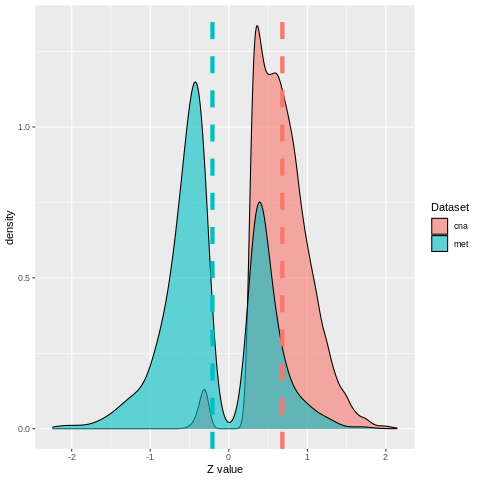

In [ ]:
%%R
#### Tool for Identification of CNAexp and METexp, Visualization of the distribution of expression of CNAexp genes and expression of METexp genes on a page, and Examination of the significance of each of those skewed distributions.
#geneCor(cna = x, exp1 = y, alternative1="greater", met = x1, exp2 = y1, alternative2="greater", method = "spearman") #compute Spearman's Rank correlation coefficients.
geneCor(dat1 = x, cordat1 = y, alternative1="less", dat2 = x1, cordat2 = y1, alternative2="greater", methodCC = "spearman") #compute Spearman's Rank correlation coefficients.

In [ ]:
%%R
#### Import cna_cor.txt and met_cor.txt
CNAexp_lihc = read.table("/content/dat1_versus_cordat1.txt", sep="\t", row.names = 1, check.names = FALSE, header = TRUE)
METexp_lihc = read.table("/content/dat2_versus_cordat2.txt", sep="\t", row.names = 1, check.names = FALSE, header = TRUE)

In [ ]:
%%R
#### CNA/MET genes significantly correlated with gene expressison
length(rownames(CNAexp_lihc))
length(rownames(METexp_lihc))

#### CNAexp and METexp genes
rna_clus = rna_clus[rownames(CNAexp_lihc),]
meth_clus = meth_clus[rownames(METexp_lihc),]

In [ ]:
%%R
remotes::install_github("cran/iCluster")





(as ‘lib’ is unspecified)



























	‘/tmp/RtmptqTNwl/downloaded_packages’



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmptqTNwl/remotes3f7154d9659a/cran-iCluster-29d70e4/DESCRIPTION’ ... OK
* preparing ‘iCluster’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘iCluster_2.1.0.tar.gz’



(as ‘lib’ is unspecified)



In [ ]:
# Cài đặt lại gói từ GitHub
!Rscript -e "remotes::install_github('taoshengxu/CancerSubtypes')"

BiocGenerics (NA -> 0.50.0 ) [CRAN]
Biobase      (NA -> 2.64.0 ) [CRAN]
Rcpp         (NA -> 1.0.12 ) [CRAN]
plyr         (NA -> 1.8.9  ) [CRAN]
iterators    (NA -> 1.0.14 ) [CRAN]
foreach      (NA -> 1.5.2  ) [CRAN]
ALL          (NA -> 1.46.0 ) [CRAN]
statmod      (NA -> 1.5.0  ) [CRAN]
BiocManager  (NA -> 1.30.23) [CRAN]
reshape2     (NA -> 1.4.4  ) [CRAN]
doParallel   (NA -> 1.0.17 ) [CRAN]
gridBase     (NA -> 0.4-7  ) [CRAN]
rngtools     (NA -> 1.5.2  ) [CRAN]
registry     (NA -> 0.5-1  ) [CRAN]
Consensus... (NA -> 1.68.0 ) [CRAN]
limma        (NA -> 3.60.3 ) [CRAN]
impute       (NA -> 1.78.0 ) [CRAN]
NMF          (NA -> 0.27   ) [CRAN]
sigclust     (NA -> 1.1.0.1) [CRAN]
Installing 19 packages: BiocGenerics, Biobase, Rcpp, plyr, iterators, foreach, ALL, statmod, BiocManager, reshape2, doParallel, gridBase, rngtools, registry, ConsensusClusterPlus, limma, impute, NMF, sigclust
Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://bioc

In [ ]:
!Rscript -e "library(CancerSubtypes)"


Loading required package: sigclust
Loading required package: NMF
Loading required package: registry
Loading required package: rngtools
Loading required package: cluster
NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 2/2
  To enable shared memory capabilities, try: install.extras('
NMF
')


In [ ]:
%%R
library(CancerSubtypes)







NMF
')

Attaching package: ‘CancerSubtypes’



    affinityMatrix, dist2




In [ ]:
%%R
#### Retain genes significantly associated with prognostic value (OS)
rna_clus=FSbyCox(rna_clus, cli_patient_lihc$time, cli_patient_lihc$status, cutoff = 0.005)
meth_clus=FSbyCox(meth_clus, cli_patient_lihc$time, cli_patient_lihc$status, cutoff = 0.005)

Exception ignored from cffi callback <function _processevents at 0x79d7bf5a04c0>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/rpy2/rinterface_lib/callbacks.py", line 278, in _processevents
    processevents()
  File "/usr/local/lib/python3.10/dist-packages/rpy2/rinterface_lib/callbacks.py", line 262, in processevents
    def processevents() -> None:
KeyboardInterrupt: 


In [ ]:
%%R
dataList <- list(meth_clus,mirna_clus,rna_clus)

In [ ]:
%%R
##3 datasets
cluster_nemo <- nemo.clustering(dataList,num.clusters = 2)

In [ ]:
%%R
print(cluster_nemo)

TCGA-2Y-A9GU-01 TCGA-2Y-A9GX-01 TCGA-2Y-A9H0-01 TCGA-2Y-A9H2-01 TCGA-2Y-A9H3-01 
              2               1               2               2               2 
TCGA-2Y-A9H4-01 TCGA-2Y-A9H6-01 TCGA-2Y-A9H7-01 TCGA-2Y-A9H9-01 TCGA-2Y-A9HB-01 
              1               1               1               1               1 
TCGA-3K-AAZ8-01 TCGA-4R-AA8I-01 TCGA-5C-A9VG-01 TCGA-5C-A9VH-01 TCGA-5C-AAPD-01 
              1               1               1               2               2 
TCGA-5R-AA1C-01 TCGA-5R-AA1D-01 TCGA-BC-4073-01 TCGA-BC-A216-01 TCGA-BC-A217-01 
              1               1               2               1               2 
TCGA-BC-A3KF-01 TCGA-BC-A3KG-01 TCGA-BC-A5W4-01 TCGA-BC-A69H-01 TCGA-BC-A69I-01 
              2               2               2               2               1 
TCGA-BC-A8YO-01 TCGA-BD-A2L6-01 TCGA-BD-A3EP-01 TCGA-BW-A5NO-01 TCGA-BW-A5NP-01 
              2               1               1               2               2 
TCGA-BW-A5NQ-01 TCGA-CC-5258

In [ ]:
%%R
str(cluster_nemo)

 Named int [1:272] 2 1 2 2 2 1 1 1 1 1 ...
 - attr(*, "names")= chr [1:272] "TCGA-2Y-A9GU-01" "TCGA-2Y-A9GX-01" "TCGA-2Y-A9H0-01" "TCGA-2Y-A9H2-01" ...


In [ ]:
%%R
cli_patient_lihc$cluster_nemo



NULL


In [ ]:
%%R
install.packages("survival")

(as ‘lib’ is unspecified)







	‘/tmp/RtmptqTNwl/downloaded_packages’



In [ ]:
%%R
library(survival)

In [ ]:
%%R
coxFit_nemo <- summary(coxph(Surv(cli_patient_lihc$time, cli_patient_lihc$status) ~ as.factor(cluster_nemo)))
    if (!is(coxFit_nemo, "try-error")) {
            pcox_nemo <- round(coxFit_nemo$sctest[3], digits = 40)
            con_nemo <- coxFit_nemo$concordance[1]
        print(paste("P-value của Cox model:", pcox_nemo))
        pval_text <- paste("P-value của Cox model:", pcox_nemo)
    } else {
        pcox_nemo <- NA
        con_nemo <- NA
        print("Error: Cox model fit failed.")
    }

[1] "P-value của Cox model: 1.00588126246327e-07"


In [41]:
!Rscript -e "remotes::install_github('kassambara/survminer')"

Streaming output truncated to the last 5000 lines.
../inst/include/Eigen/src/Householder/HouseholderSequence.h:364:25:   required from ‘void Eigen::HouseholderSequence<VectorsType, CoeffsType, Side>::applyThisOnTheLeft(Dest&, bool) const [with Dest = Eigen::Matrix<double, -1, 1>; VectorsType = Eigen::Matrix<double, -1, -1>; CoeffsType = Eigen::Matrix<double, -1, 1>; int Side = 1]’
../inst/include/Eigen/src/Householder/HouseholderSequence.h:427:25:   required from ‘typename Eigen::internal::matrix_type_times_scalar_type<typename Eigen::internal::traits<Eigen::HouseholderSequence<VectorsType, CoeffsType, Side> >::Scalar, OtherDerived>::Type Eigen::HouseholderSequence<VectorsType, CoeffsType, Side>::operator*(const Eigen::MatrixBase<OtherDerived>&) const [with OtherDerived = Eigen::Map<Eigen::Matrix<double, -1, 1>, 0, Eigen::Stride<0, 0> >; VectorsType = Eigen::Matrix<double, -1, -1>; CoeffsType = Eigen::Matrix<double, -1, 1>; int Side = 1; typename Eigen::internal::matrix_type_times_scal

In [44]:
%%R
library(survminer)


Attaching package: ‘survminer’



    myeloma




In [45]:
%%R
cli_patient_lihc$cluster_nemo = as.factor(cluster_nemo)

In [46]:
%%R
fit <- survfit(Surv(time, status) ~ cluster_nemo, data = cli_patient_lihc)

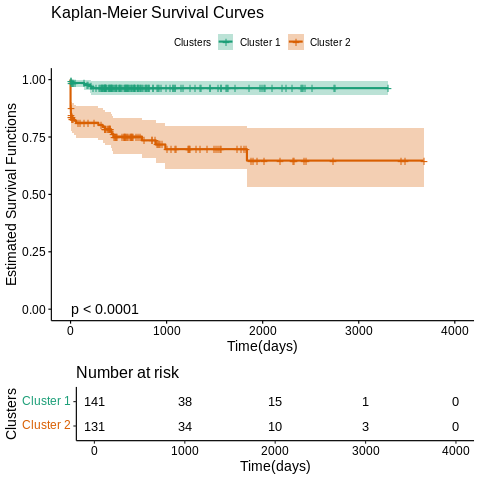

In [47]:
%%R
ggsurvplot(fit,
           data = cli_patient_lihc,
           risk.table = TRUE,
           pval = TRUE,  # Add this to show p-value on the plot
           pval.coord = c(0, 0.0000000000000000000000000000000005),  # Adjust the position of the p-value text if needed
           conf.int = TRUE,
           palette = "Dark2",
           legend.labs = c("Cluster 1", "Cluster 2"),
           legend.title = "Clusters",
           title = "Kaplan-Meier Survival Curves",
           xlab = "Time(days)",
           ylab = "Estimated Survival Functions")



In [48]:
%%R
#### Age factor


cli_patient_lihc_old1 = cli_patient_lihc[cli_patient_lihc$cluster_nemo == 1,]
cli_patient_lihc_old2 = cli_patient_lihc[cli_patient_lihc$cluster_nemo == 2,]

In [ ]:
%%R
#### Set 2 group of old and non-old patients in each Integrative Subgroups
#cli_patient_lihc_old1$Old = ifelse(cli_patient_lihc_old1$AGE >65, 1, 0)
#cli_patient_lihc_old2$Old = ifelse(cli_patient_lihc_old2$AGE >65, 1, 0)

In [49]:
%%R
# Average age of each Integrative Subgroups
mean(cli_patient_lihc_old1$AGE)


[1] 60.4539


In [50]:
%%R
mean(cli_patient_lihc_old2$AGE)

[1] 55.74046


In [51]:
%%R
#### Survival rate
age_factor1 = cli_patient_lihc_old1$Old
age_factor2 = cli_patient_lihc_old2$Old

In [52]:
%%R
# Chuyển đổi các biến thành dạng số
cli_patient_lihc_old1$DAYS_LAST_FOLLOWUP <- as.numeric(cli_patient_lihc_old1$DAYS_LAST_FOLLOWUP)

# Chuyển đổi OS_STATUS từ LIVING/DECEASED thành 0/1
cli_patient_lihc_old1$OS_STATUS <- ifelse(cli_patient_lihc_old1$OS_STATUS == "LIVING", 0,
                                          ifelse(cli_patient_lihc_old1$OS_STATUS == "DECEASED", 1, NA))

# Thay thế các giá trị NA bằng giá trị trung vị của biến tương ứng
median_followup <- median(cli_patient_lihc_old1$DAYS_LAST_FOLLOWUP, na.rm = TRUE)

cli_patient_lihc_old1$DAYS_LAST_FOLLOWUP[is.na(cli_patient_lihc_old1$DAYS_LAST_FOLLOWUP)] <- median_followup
cli_patient_lihc_old1$OS_STATUS[is.na(cli_patient_lihc_old1$OS_STATUS)] <- 0 # Hoặc chọn giá trị phù hợp

# Lọc các hàng có giá trị OS_STATUS hợp lệ
cli_patient_lihc_old1 <- cli_patient_lihc_old1[cli_patient_lihc_old1$OS_STATUS %in% c(0, 1), ]

# Chạy mô hình Cox
coxFit.age1 <- coxph(
  Surv(DAYS_LAST_FOLLOWUP, OS_STATUS) ~ as.factor(age_factor1),
  data = cli_patient_lihc_old1,
  ties = "exact"
)

# Tính giá trị p-value
pcox.age1 <- summary(coxFit.age1)$logtest[3]
pcox.age1



  variable lengths differ (found for 'as.factor(age_factor1)')





Error in model.frame.default(formula = Surv(DAYS_LAST_FOLLOWUP, OS_STATUS) ~  : 
  variable lengths differ (found for 'as.factor(age_factor1)')


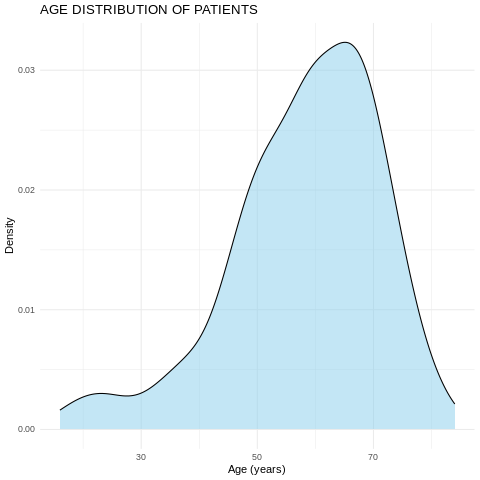

In [53]:
%%R
# Remove NA values from age column
cli_patient_lihc<- cli_patient_lihc[!is.na(cli_patient_lihc$AGE), ]

# Plot the age distribution
ggplot(cli_patient_lihc, aes(x = AGE)) +
  geom_density(fill = "skyblue", alpha = 0.5) +
  labs(title = "AGE DISTRIBUTION OF PATIENTS", x = "Age (years)", y = "Density") +
  theme_minimal()


In [54]:
!Rscript -e "remotes::install_github('huynguyen250896/GeneCluster')"

maps        (NA    -> 3.4.2) [CRAN]
textshaping (0.3.6 -> 0.4.0) [CRAN]
Installing 2 packages: maps, textshaping
Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/maps_3.4.2.tar.gz'
Content type 'application/x-gzip' length 2278051 bytes (2.2 MB)
downloaded 2.2 MB

trying URL 'https://cran.rstudio.com/src/contrib/textshaping_0.4.0.tar.gz'
Content type 'application/x-gzip' length 37960 bytes (37 KB)
downloaded 37 KB

* installing *source* package ‘maps’ ...
** package ‘maps’ successfully unpacked and MD5 sums checked
** using staged installation
checking for gawk... no
checking for mawk... mawk
configure: creating ./config.status
config.status: creating src/Makefile
** libs
make -f "/usr/lib/R/etc/Makeconf" -f Makefile init.o mapclip.o mapget.o smooth.o thin.o 
make[1]: Entering directory '/tmp/RtmpYHf29i/R.INSTALL87e41bfd6b19/maps/src'
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix

In [55]:
%%R
library(GeneCluster)

In [56]:
%%R
install.packages("maps")

(as ‘lib’ is unspecified)







	‘/tmp/RtmptqTNwl/downloaded_packages’



In [57]:
%%R
library(maps)

Attaching package: ‘maps’



    votes.repub



    map




In [58]:
%%R
exp_cor_lihc=rbind(c_exp1_lihc, c_exp2_lihc); exp_cor_lihc=t(exp_cor_lihc) #combining two corresponding mRNA datasets to one

In [59]:
%%R
#Integrative Subgroups Specific Genes
SubtypeSpecificGene(omics = exp_cor_lihc , cluster = cluster_nemo)

        GeneCluster mean in Subgroup 1 mean in Subgroup 2      P.value
MAT1A             1          0.4009128         -0.8232397 5.823522e-29
MAT1A.1           1          0.4009128         -0.8232397 5.823522e-29
LRRC1             2         -0.4780532          0.7675901 8.592858e-26
LRRC1.1           2         -0.4780532          0.7675901 8.592858e-26
GRHPR             1          0.2750504         -0.8293748 1.532793e-25
GRHPR.1           1          0.2750504         -0.8293748 1.532793e-25
             Q.value
MAT1A   9.963659e-25
MAT1A.1 9.963659e-25
LRRC1   6.300774e-22
LRRC1.1 6.300774e-22
GRHPR   7.152289e-22
GRHPR.1 7.152289e-22

NOTE: 
*the results shown above are incomplete.
*subtype_specific_gene.csv placed in your current working directory.
*Please check to identify which gene is specifically assigned to which subgroup.
NULL


In [60]:
%%R
# Create annotation data frame
annotation_data <- data.frame(
  IntCl = factor(cluster_nemo, labels = c("IntCl1", "IntCl2")),
  CNAevents = colSums(abs(rna_clus) > 0), # Sum of CNA events per patient
  METevents = colSums(abs(meth_clus) > 0) # Sum of MET events per patient
)

In [61]:
%%R
install.packages("ComplexHeatmap")
install.packages("circlize")


(as ‘lib’ is unspecified)

(as ‘lib’ is unspecified)



















	‘/tmp/RtmptqTNwl/downloaded_packages’



In [64]:
%%R
devtools::install_github("jokergoo/ComplexHeatmap")



(as ‘lib’ is unspecified)
































	‘/tmp/RtmptqTNwl/downloaded_packages’



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmptqTNwl/remotes3f717ecaecff/jokergoo-ComplexHeatmap-7d95ca5/DESCRIPTION’ ... OK
* preparing ‘ComplexHeatmap’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘ComplexHeatmap_2.15.4.tar.gz’



(as ‘lib’ is unspecified)

  Use `force = TRUE` to force installation



In [75]:
%%R
library(ComplexHeatmap)
library(circlize)

In [84]:
%%R
# Create HeatmapAnnotation
ha <- HeatmapAnnotation(
  IntCl = annotation_data$IntCl,
  CNAevents = annotation_data$CNAevents,
  METevents = annotation_data$METevents,
  col = list(IntCl = c("IntCl1" = "pink", "IntCl2" = "turquoise"),
             CNAevents = colorRamp2(c(0, max(annotation_data$CNAevents)), c("white", "red")),
             METevents = colorRamp2(c(0, max(annotation_data$METevents)), c("white", "blue")))
)

In [86]:
%%R
# Combine expression matrices for heatmap
combined_matrix <- rbind(rna_clus,meth_clus)

# Create heatmap
ht <- Heatmap(combined_matrix,
              name = "expression",
              top_annotation = ha,
              show_row_names = FALSE,
              show_column_names = FALSE,
              cluster_columns = FALSE,
              cluster_rows = FALSE,
              col = colorRamp2(c(-2, 0, 2), c("blue", "white", "red")))

In [83]:
%%R
dim (rna_clus)


[1] 348 272


In [82]:
%%R
dim (meth_clus)

[1] 114 272


In [87]:
%%R
heatmap <- Heatmap(rna_clus,
                   name = "CNA events",
                   top_annotation = ha,
                   show_column_names = FALSE,
                   cluster_columns = FALSE,
                   show_row_names = FALSE)

heatmap2 <- Heatmap(meth_clus,
                    name = "MET events",
                    top_annotation = ha,
                    show_column_names = FALSE,
                    cluster_columns = FALSE,
                    show_row_names = FALSE)

draw(heatmap + heatmap2, heatmap_legend_side = "right", annotation_legend_side = "right")

  error in evaluating the argument 'object' in selecting a method for function 'draw': `nrow` of all heatmaps and `nobs` of all annotations should be the same
for horizontal heatmap list.
  heatmap 'CNA events': 348
  heatmap 'MET events': 114




Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'object' in selecting a method for function 'draw': `nrow` of all heatmaps and `nobs` of all annotations should be the same
for horizontal heatmap list.
  heatmap 'CNA events': 348
  heatmap 'MET events': 114
